# Abrupt transitions

In this section, we illustrate complex phenomena around abrupt transitions in the parameter space of CRLD. In this example, we focus on the discount factor, which indicates how much the agents care for future rewards. Abrupt transitions go by many names, such as critical transitions, regime shifts, bifurcations, or tipping elements, to name some of them.

First, we import everything we need:

In [1]:
#| echo: false
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood as EPG
from pyCRLD.Agents.StrategyActorCritic import stratAC

import _code.SimulationScripts as sim 

## Compute data
We start by computing the CRLD trajectories from 250 random initial strategies along a varying discount factor.

In [3]:
# Set data trajectory for storing results, e.g.,
ddir = '/Users/wolf/Downloads/CoCoIn_data'

# Initialize first environment and multi-agent environment interface (MAEi)
env = EPG(N=2, f=1.2, c=5, m=-5, qc=0.2, qr=0.01, degraded_choice=False)
MAEi = stratAC(env=env, learning_rates=0.1, discount_factors=0.99, use_prefactor=True)

# Create random initial strategies from simulation scripts 'sim'
Xs = sim.initial_strategies(MAEi, 250)

# Create discount factors to loop through
discountfacts = np.sort(np.unique(list(np.linspace(0.1, 1.0, 10)[:-1].round(2))
                        + list(np.arange(0.5, 1.0, 0.05).round(2))
                        + list(np.arange(0.65, 0.9, 0.0125).round(4)) 
                        + [0.01, 0.99]))
print("Discount factors:")
print(discountfacts)

Discount factors:
[0.01   0.1    0.2    0.3    0.4    0.5    0.55   0.6    0.65   0.6625
 0.675  0.6875 0.7    0.7125 0.725  0.7375 0.75   0.7625 0.775  0.7875
 0.8    0.8125 0.825  0.8375 0.85   0.8625 0.875  0.8875 0.9    0.95
 0.99  ]


In [4]:
#| output: false

# compute or load the data from disk (if they exist)
convtimes = []; rewss = []; coops = []
for dcf in discountfacts:
    print(f" = = = = {dcf} = = = =")
    MAEi = stratAC(env=env, learning_rates=0.1, discount_factors=dcf,
                   use_prefactor=False)
    
    trjs, fprs = sim.obtain_trajectories(MAEi, Xs, 25000, ddir=ddir)

    # convergence times
    convtimes.append([len(trj) for trj in trjs])
    
    # final rewards
    rewss.append(sim.final_rewards(MAEi, trjs))
    
    # cooperative acts
    coops.append([trj[-1].astype(float)[:,1,0] for trj in trjs])

 = = = = 0.01 = = = =
Loading  /Users/wolf/Downloads/CoCoIn_data/EcologicalPublicGood_2_1.2_5_-5_0.2_0.01_NoDegChoi__jstratAC_[0.1 0.1]_[0.01 0.01]_[1. 1.]preFalse_14689158158224751419.npz
 = = = = 0.1 = = = =
Loading  /Users/wolf/Downloads/CoCoIn_data/EcologicalPublicGood_2_1.2_5_-5_0.2_0.01_NoDegChoi__jstratAC_[0.1 0.1]_[0.1 0.1]_[1. 1.]preFalse_14689158158224751419.npz
 = = = = 0.2 = = = =
Loading  /Users/wolf/Downloads/CoCoIn_data/EcologicalPublicGood_2_1.2_5_-5_0.2_0.01_NoDegChoi__jstratAC_[0.1 0.1]_[0.2 0.2]_[1. 1.]preFalse_14689158158224751419.npz
 = = = = 0.3 = = = =
Loading  /Users/wolf/Downloads/CoCoIn_data/EcologicalPublicGood_2_1.2_5_-5_0.2_0.01_NoDegChoi__jstratAC_[0.1 0.1]_[0.3 0.3]_[1. 1.]preFalse_14689158158224751419.npz
 = = = = 0.4 = = = =
Loading  /Users/wolf/Downloads/CoCoIn_data/EcologicalPublicGood_2_1.2_5_-5_0.2_0.01_NoDegChoi__jstratAC_[0.1 0.1]_[0.4 0.4]_[1. 1.]preFalse_14689158158224751419.npz
 = = = = 0.5 = = = =
Loading  /Users/wolf/Downloads/CoCoIn_data/Eco

## Plotting function {#sec-plotfunc}
Next, we create a function to plot the data along the varying parameter.

In [5]:
def plot_valuehistograms_vs_parameters(parameters, values, bins, rnge,
                                       marker='.', alpha=1.0, color='black',
                                       cmap='viridis', ax=None):
    """
    Plot a histogram for each parameter next to each other.
    
    Parameters
    ----------
    parameters: iterable
        of float-valued parameters
    values: iterable
        of iterable of values for each parameter
    bins: int
        The number of bins for the histograms
    rnge: tupe
        Range of the histogram as (min, max)   
    """
    # Figure
    if ax is None:
        _, ax = plt.subplots()

    # Create iterable of histograms for values
    valhist=[]
    for conv in values:
        h = np.histogram(conv, bins=bins, range=rnge)[0]
        valhist.append(h)

    # Adjust spacing
    params = np.array(parameters)
    delta = params[1:] - params[:-1]
    paramedges = np.concatenate(([parameters[0]-0.5*delta[0]],
                                parameters[:-1] + 0.5*delta,
                                [parameters[-1]+0.5*delta[-1]]))
    valedges = np.linspace(rnge[0], rnge[1], bins+1)

    # Plot histograms with colormap
    X, Y = np.meshgrid(paramedges, valedges)
    ax.pcolormesh(X, Y, np.array(valhist).T, cmap=cmap, alpha=alpha*0.75)

    # Plot median, quantiles and mean
    quartile1, medians, quartile3 = np.percentile(values, [25, 50, 75], axis=1)
    ax.fill_between(params, quartile1, quartile3, color=color, alpha=alpha*0.2)
    ax.plot(params, medians, marker=marker, markersize=4, linestyle='-', 
            color=color, alpha=0.5*alpha)
    ax.plot(params, np.mean(values, axis=1), marker=marker, linestyle='',
            color=color, alpha=alpha)
    
    # Adjust the visible y range
    ax.set_ylim(rnge[0], rnge[1])

## Abrupt transition
We use the created plotting function (@sec-plotfunc) to visualize the phenomenon of an abrupt transition from complete defection to complete cooperation.

We show the abrupt transition in the level of cooperation at convergence. 

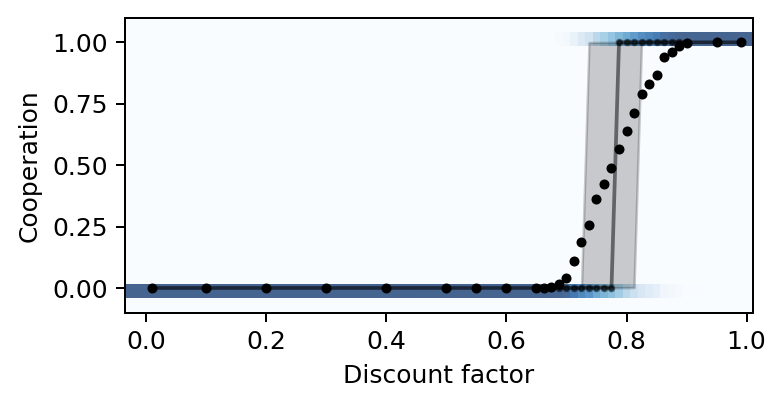

In [6]:
#| fig-cap: "Abrupt transition in final cooperation likelihood"

# Create the canves    
fsf = 0.7  # figure size factor
fig, ax = plt.subplots(figsize=(fsf*6, fsf*3))    

# Plot the cooperation probabilities versus the discount factors
plot_valuehistograms_vs_parameters(parameters=discountfacts,
                                   values=np.array(coops).mean(-1), ax=ax,
                                   bins=21, rnge=(-0.1, 1.1), cmap='Blues')

# Make labels and axis nice
plt.ylabel('Cooperation')
plt.xlabel('Discount factor')

# Save plot
plt.subplots_adjust(left=0.15, right=0.98, top=0.98, bottom=0.2)

We also show the abrupt transition in the level of final rewards obtained by the agents.

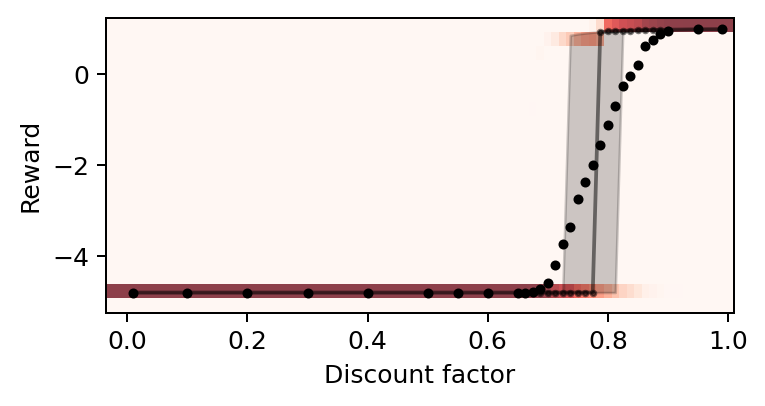

In [7]:
#| fig-cap: "Abrupt transition in final rewards"

# Create the canves    
fsf = 0.7  # figure size factor
fig, ax = plt.subplots(figsize=(fsf*6, fsf*3))    

# Plot the reward levels versus the discount factors
plot_valuehistograms_vs_parameters(parameters=discountfacts,
                                   values=np.array(rewss).mean(-1), ax=ax,
                                   bins=21, rnge=(-5.25, 1.25), cmap='Reds')

# Make labels and axis nice
plt.ylabel('Reward')
plt.xlabel('Discount factor')
plt.subplots_adjust(left=0.15, right=0.98, top=0.98, bottom=0.2)

Since the transition from complete defection to complete cooperation and from low reward and high reward appear similar, we can also try to plot them together into one plot, with cooperation on the left y-axis and the reward on the right y-axis.

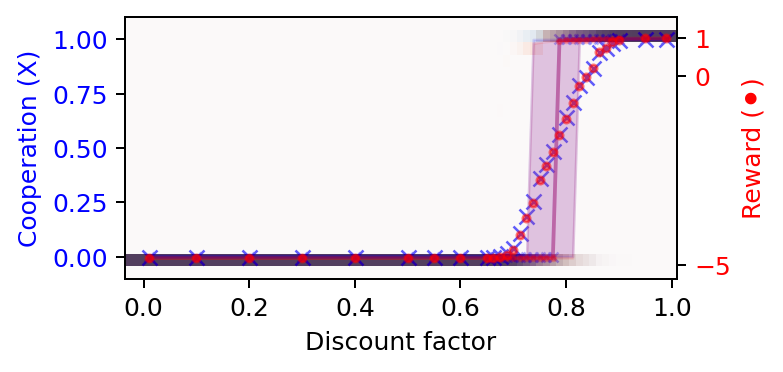

In [10]:
#| fig-cap: "Abrupt transition in final cooperation likelihood and in final rewards"

# Create the canves    
fsf = 0.7  # figure size factor
fig, ax1 = plt.subplots(figsize=(fsf*6, fsf*2.8))    
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plot the cooperation probabilities versus the discount factors
plot_valuehistograms_vs_parameters(parameters=discountfacts,
                                   values=np.array(coops).mean(-1), ax=ax1,
                                   bins=21, rnge=(-0.1, 1.1), cmap='Blues',
                                   marker='x', color='blue')

# Plot the reward levels versus the discount factors
plot_valuehistograms_vs_parameters(parameters=discountfacts,
                                   values=np.array(rewss).mean(-1), ax=ax2,
                                   bins=21, rnge=(-5.35, 1.55), cmap='Reds',
                                   marker='.', alpha=0.5, color='red')

# Make labels and axis nice
ax1.set_xlabel('Discount factor')
ax1.set_ylabel('Cooperation (X)', color='Blue')
ax1.tick_params(axis='y', labelcolor='Blue')
ax2.set_ylabel('Reward (⚫️)', color='Red')
ax2.tick_params(axis='y', labelcolor='Red')
ax2.set_yticks([-5, 0, 1]);
plt.subplots_adjust(left=0.15, right=0.88, top=0.96, bottom=0.22)
plt.savefig('_figs/fig_02AbruptTransitionCooperationReward.png', dpi=150)

## Critical slowing down
We use the created plotting function (@sec-plotfunc) to visualize the phenomenon of a critical slowing down of the learning speed around the tipping point.

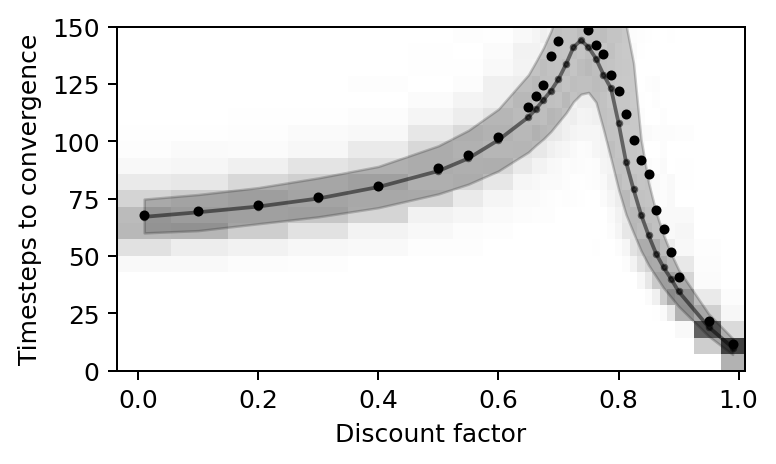

In [11]:
#| fig-cap: "Critical slowing down in parameter space"

# Create the canves    
fsf = 0.7 # figure size factor
fig, ax = plt.subplots(figsize=(fsf*6, fsf*3.5))    

# Plot the convergence times versus the discount factors
plot_valuehistograms_vs_parameters(parameters=discountfacts, values=convtimes,
                                   bins=21, rnge=(0, 150), cmap='Greys', ax=ax)

# Make labels and axis nice
plt.ylabel('Timesteps to convergence')
plt.xlabel('Discount factor')

# Save plot
plt.subplots_adjust(left=0.15, right=0.98, top=0.96, bottom=0.18)
plt.savefig('_figs/fig_02AbruptTransitionSpeed.png', dpi=150)